# Overview
This is an example of how someone might generate and store models that can be compared for fairness. 

In [1]:
from IPython.display import Markdown
from fairMLHealth.utils import helpers, model_comparison
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


----
# Part 1 - Loading the Data <a class="anchor" id="part1"></a>


## Loading MIMIC III Data
As mentioned above, the MIMIC-III data download contains a folder of zipped_files. The tutorial code in the [Data Subset](#datasubset) section below will automatically unzip and format all necessary data for these experiments, saving the formatted data in the same MIMIC folder. Simply enter the correct path of the MIMIC folder in the following cell to enable this feature. Your path should end with the directory "MIMIC".

Example: path_to_mimic_data_folder = "~/data/MIMIC"

In [2]:
# path_to_mimic_data_folder = "[path to your downloaded data folder]"
path_to_mimic_data_folder = "~/data/MIMIC"

In [3]:
# output file for combined data and models
output_file = os.path.expanduser("~/data/fairness_and_bias/mimic_model_comparison/regression.joblib")


## Data Subset <a id="datasubset"></a>
Example models in this notebook use data from all years of the MIMIC-III dataset for patients aged 65 and older. Data are imported at the encounter level with all additional patient identification dropped. All models include an "AGE" feature, simplified to 5-year bins, as well as boolean diagnosis and procedure features categorized through the Clinical Classifications Software system ([HCUP](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)). All features other than age are one-hot encoded and prefixed with their variable type (e.g. "GENDER_", "ETHNICITY_").  

In [4]:
df = helpers.load_mimic3_example(path_to_mimic_data_folder) 
df.drop('GENDER_F', axis=1, inplace=True)
df = df.loc[df['AGE'].ge(65),:]
helpers.print_feature_table(df)
display(Markdown('---'))
display(df.head())


 This data subset has 22434 total observations and 648 input features 



,Raw Feature,Category Count (Encoded Features)
0,AGE,1
1,DIAGNOSIS,282
2,ETHNICITY,41
3,GENDER,1
4,INSURANCE,5
5,LANGUAGE,69
6,MARRIED,7
7,PROCEDURE,222
8,RELIGION,20


---

,ADMIT_ID,AGE,GENDER_M,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETHNICITY_ASIAN,ETHNICITY_ASIAN - ASIAN INDIAN,ETHNICITY_ASIAN - CAMBODIAN,ETHNICITY_ASIAN - CHINESE,ETHNICITY_ASIAN - FILIPINO,...,PROCEDURE_CCS_222,PROCEDURE_CCS_223,PROCEDURE_CCS_224,PROCEDURE_CCS_225,PROCEDURE_CCS_226,PROCEDURE_CCS_227,PROCEDURE_CCS_228,PROCEDURE_CCS_229,PROCEDURE_CCS_231,length_of_stay
0,472456,65.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.144444
1,459364,70.0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,5.496528
2,431462,75.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.768056
5,504802,70.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,6.988889
7,469710,75.0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,5.364583


,count,mean,std,min,25%,50%,75%,max
length_of_stay,22434.000000,9.115200,6.208700,0.004200,4.735200,7.579900,12.017700,29.988900


---

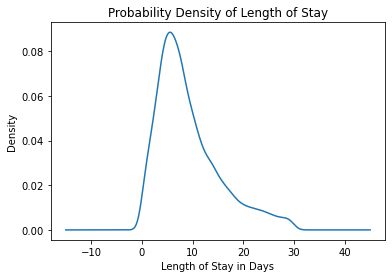

In [5]:
# 
los_tbl = df[['length_of_stay']].describe().transpose().round(4)
display(los_tbl.style.applymap(helpers.highlight_col, subset=pd.IndexSlice[:, 'mean']))

# Display LOS distributions
display(Markdown('---'))
ax = df['length_of_stay'].plot(kind='kde', title="Probability Density of Length of Stay")
ax.set_xlabel("Length of Stay in Days")
plt.show()


/Users/christineallen/anaconda3/envs/fairMLHealth/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='length_of_stay', ylabel='Density'>

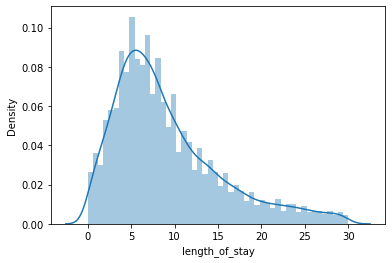

In [6]:
import seaborn as sns
sns.distplot(df['length_of_stay'])

----
# Part 2 - Train Length of Stay Models

In [7]:
# Shared Functions
from sklearn.model_selection import train_test_split
import sklearn.metrics as sk_metric
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from joblib import dump

## Baseline - Random Sampling

/Users/christineallen/anaconda3/envs/fairMLHealth/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  import sys


norm KstestResult(statistic=0.11438360829186422, pvalue=3.781055439815576e-256)
lognorm KstestResult(statistic=0.015954471141469972, pvalue=2.1683592592623385e-05)


/Users/christineallen/anaconda3/envs/fairMLHealth/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


beta KstestResult(statistic=0.029666909904619843, pvalue=1.3778188142563033e-17)
rayleigh KstestResult(statistic=0.09761075880134551, pvalue=1.6605674418529897e-186)


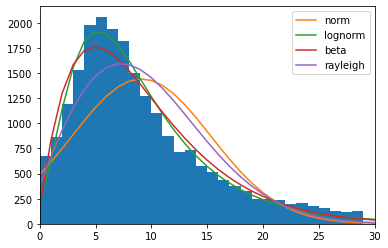

In [8]:
import matplotlib.pyplot as plt
import scipy
import scipy.stats
y = df['length_of_stay'].values
size = len(y)
lim = int(np.ceil(df['length_of_stay'].max()))
x = scipy.arange(size)

# iterate through suspected distributions to determine best fit
dist_names = ['norm', 'lognorm', 'beta', 'rayleigh']

h = plt.hist(y, bins=range(lim))
results = {}
for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
    plt.plot(pdf_fitted, label=dist_name)
    plt.xlim(0,lim)
    results[dist_name] = pdf_fitted
    print(dist_name, scipy.stats.kstest(y, dist_name, param))
plt.legend(loc='upper right')
plt.show()



In [9]:
import scipy.stats
import sklearn.metrics as skmetric

# generate "predictions" as random sample of target values
y_test = df['length_of_stay']
y_pred_baseline = results['beta']

# display baseline performance 
print("\n", "Prediction Scores for Random Sampling:", "\n",
        model_comparison.regression_report(y_test, y_pred_baseline) )


 Prediction Scores for Random Sampling: 
               Score
Rsqrd    -33.220046
MeanAE    10.084537
MeanSE  1319.050493


## Split Data for other Models

In [10]:
# Subset and Split Data
X = df.loc[:,[c for c in df.columns if c not in ['ADMIT_ID','length_of_stay']]]
y = df.loc[:,['length_of_stay']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)



## Linear Regression (OLS)

In [11]:
from sklearn import linear_model

# Set model parameters (currently set as default values, but defined here to be explicit)
lr_params = {}

# Train Model
reg_model = linear_model.LinearRegression(**lr_params)
reg_model.fit(X_train, y_train.iloc[:,0])
y_pred_reg = reg_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      model_comparison.regression_report(y_test, y_pred_reg) )


 Prediction Scores: 
                Score
Rsqrd  -2.267502e+17
MeanAE  9.249711e+07
MeanSE  8.559478e+18


## Ridge Regression

In [12]:
from sklearn import linear_model

# Set model parameters (currently set as default values, but defined here to be explicit)
ridge_params = {}

# Train Model
ridge_model = linear_model.Ridge(**ridge_params)
ridge_model.fit(X_train, y_train.iloc[:,0])
y_pred_ridge = ridge_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      model_comparison.regression_report(y_test, y_pred_ridge) )


 Prediction Scores: 
             Score
Rsqrd    0.513088
MeanAE   3.198865
MeanSE  18.380190


## Lasso

In [13]:
from sklearn import linear_model

# Set model parameters (currently set as default values, but defined here to be explicit)
lasso_params = {}

# Train Model
lasso_model = linear_model.Lasso(**lasso_params)
lasso_model.fit(X_train, y_train.iloc[:,0])
y_pred_lasso = lasso_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      model_comparison.regression_report(y_test, y_pred_lasso) )


 Prediction Scores: 
             Score
Rsqrd    0.025066
MeanAE   4.746270
MeanSE  36.802304


## Elastic Net

In [14]:
from sklearn import linear_model

# Set model parameters (currently set as default values, but defined here to be explicit)
en_params = {}

# Train Model
en_model = linear_model.ElasticNet(**en_params)
en_model.fit(X_train, y_train.iloc[:,0])
y_pred_en = en_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      model_comparison.regression_report(y_test, y_pred_en) )


 Prediction Scores: 
             Score
Rsqrd    0.063350
MeanAE   4.643471
MeanSE  35.357141


## Multi-Task Elastic Net

In [15]:
from sklearn import linear_model

# Set model parameters (currently set as default values, but defined here to be explicit)
mten_params = {}

# Train Model
mten_model = linear_model.ElasticNet(**mten_params)
mten_model.fit(X_train, y_train.iloc[:,0])
y_pred_mten = mten_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      model_comparison.regression_report(y_test, y_pred_mten) )


 Prediction Scores: 
             Score
Rsqrd    0.063350
MeanAE   4.643471
MeanSE  35.357141


## LassoLars

In [16]:

from sklearn import linear_model

# Set model parameters (currently set as default values, but defined here to be explicit)
llars_params = {}

# Train Model
llars_model = linear_model.LassoLars(**llars_params)
llars_model.fit(X_train, y_train.iloc[:,0])
y_pred_llars = llars_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      model_comparison.regression_report(y_test, y_pred_llars) )


 Prediction Scores: 
             Score
Rsqrd   -0.001467
MeanAE   4.815731
MeanSE  37.803871


## BayesianRidge

In [17]:
from sklearn import linear_model

# Set model parameters (currently set as default values, but defined here to be explicit)
br_params = {}

# Train Model
br_model = linear_model.BayesianRidge(**br_params)
br_model.fit(X_train, y_train.iloc[:,0])
y_pred_br = br_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      model_comparison.regression_report(y_test, y_pred_br) )


 Prediction Scores: 
             Score
Rsqrd    0.516628
MeanAE   3.187285
MeanSE  18.246578


In [22]:
from sklearn.linear_model import BayesianRidge

## XGBOOST Model

In [18]:
from xgboost import XGBRegressor

# Set model parameters
xgb_params = {'reg':"squarederror"}
#{'colsample_bytree': 1.0, 'gamma': 2, 'learning_rate': 0.05, 'max_depth': 5, 
#                'min_child_weight': 1,  'n_estimators': 600, 'subsample': 0.6}

# Train Model
xgb_model = XGBRegressor(**xgb_params)
xgb_model.fit(X_train, y_train.iloc[:,0])
y_pred_xgb = xgb_model.predict(X_test)




[16:55:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { reg } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [19]:
# display performance 
print("\n", "XGBOOST Prediction Scores:", "\n", 
      model_comparison.regression_report(y_test, y_pred_xgb) )


 XGBOOST Prediction Scores: 
             Score
Rsqrd    0.495921
MeanAE   3.218818
MeanSE  19.028243


## FairLearn

In [27]:
from fairlearn.reductions import GridSearch, ExponentiatedGradient, GroupLossMoment, SquareLoss


min_val = 0
max_val = int(y_test.max()[0])
bgl_constraint = GroupLossMoment(SquareLoss(-np.inf, np.inf))
gs_lgb_model = GridSearch(BayesianRidge(**br_params),
                           constraints=bgl_constraint,
                           grid_size=50)

gs_lgb_model.fit(X_train, y_train, sensitive_features=X_train['LANGUAGE_ENGL'])
y_pred_glgb = gs_lgb_model.predict(X_test)


In [34]:


gl_constraint = GroupLossMoment(SquareLoss(-np.inf, np.inf))
eg_model = ExponentiatedGradient(BayesianRidge(**br_params),
                                    constraints=gl_constraint)

eg_model.fit(X_train, y_train, sensitive_features=X_train['LANGUAGE_ENGL'])
y_pred_eg = eg_model.predict(X_test)


TypeError: signed_weights() missing 1 required positional argument: 'lambda_vec'

In [ ]:

# display performance 
print("\n", "Prediction Scores:", "\n", 
      model_comparison.regression_report(y_test, y_pred_exg) )


In [ ]:
from fairlearn.reductions._moments import bounded_group_loss, ZeroOneLoss
from fairlearn.metrics import mean_absolute_error_group_summary


bgl = bounded_group_loss.BoundedGroupLoss(ZeroOneLoss(), upper_bound=0.1)
mean_absolute_error_group_summary(y_test, y_pred_xgb, sensitive_features=X_train['LANGUAGE_ENGL'])

bgl.load_data(X_test, y_test, sensitive_features=X_train['LANGUAGE_ENGL'])

bgl.gamma(lambda X: y_pred_xgb)

In [ ]:
from fairlearn.reductions._moments import bounded_group_loss, ZeroOneLoss

min_val = 0
max_val = int(y_test.max()[0])
loss= bounded_group_loss.AbsoluteLoss(min_val, max_val)
bgm = bounded_group_loss.ConditionalLossMoment(loss, no_groups=False)

----
# Part 3 - Model Comparison

In [ ]:
# (Optional) View this model in Fairlearn's fairness dashboard, and see the disparities which appear:
from fairlearn.widget import FairlearnDashboard
FairlearnDashboard(sensitive_features=X_test['LANGUAGE_ENGL'], 
                   sensitive_feature_names=['LANGUAGE_ENGL'],
                   y_true=y_test,
                   y_pred={"y_pred_br":y_pred_br, "y_pred_xgb":y_pred_xgb,  "y_pred_en":y_pred_en})

# Save Model Packet

In [ ]:
models = {'naive_bayes_model':nb_model,'random_forest_model':rf_model, 'xgboost_model':xgb_model}
packet = model_comparison.fairCompare(test_data=X_test, target_data=y_test, models=models)
if not os.path.exists(os.path.dirname(output_file)):
        os.makedirs(output_file)
dump(packet, output_file)